## Import

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

---

## Set up variables

In [2]:
COMPANY = 'AAPL'
START = dt.datetime(2013, 1, 1)
END = dt.datetime.now()
TRAIN = 6 * 365 # 5 years

scaler = MinMaxScaler(feature_range=(0, 1))

col = ['Date', 'Current Value (X)', 'Next Value (Y)']

def show_df(data, col):
    df = pd.DataFrame(data).T
    df.columns = col
    return df

---

## Data preparation

In [3]:
data = yf.download(COMPANY, start=START, end=END)
date = data.index.values[:-1]
data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
# data = data['Close'].values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [4]:
x_data = data[:-1]
y_data = data[1:]
show_df([date, x_data, y_data], col)

,Date,Current Value (X),Next Value (Y)
0,2013-01-02,[0.031017182216994163],[0.02966103931269752]
1,2013-01-03,[0.02966103931269752],[0.026706089821681434]
2,2013-01-04,[0.026706089821681434],[0.026099446292248057]
3,2013-01-07,[0.026099446292248057],[0.02637536531889194]
4,2013-01-08,[0.02637536531889194],[0.024768741322531596]
...,...,...,...
2713,2023-10-12,[0.9137546580604929],[0.9035630133225487]
2714,2023-10-13,[0.9035630133225487],[0.9028506675456446]
2715,2023-10-16,[0.9028506675456446],[0.8942480053769565]
2716,2023-10-17,[0.8942480053769565],[0.8870700347620768]


### Training data

In [5]:
train_date = date[:TRAIN]
x_train = x_data[:TRAIN]
y_train = y_data[:TRAIN]
show_df([train_date, x_train, y_train], col)

,Date,Current Value (X),Next Value (Y)
0,2013-01-02,[0.031017182216994163],[0.02966103931269752]
1,2013-01-03,[0.02966103931269752],[0.026706089821681434]
2,2013-01-04,[0.026706089821681434],[0.026099446292248057]
3,2013-01-07,[0.026099446292248057],[0.02637536531889194]
4,2013-01-08,[0.02637536531889194],[0.024768741322531596]
...,...,...,...
2185,2021-09-07,[0.7821399968682287],[0.7734825710277247]
2186,2021-09-08,[0.7734825710277247],[0.7677840556384693]
2187,2021-09-09,[0.7677840556384693],[0.7398391990190113]
2188,2021-09-10,[0.7398391990190113],[0.743017247766183]


### Test data

In [6]:
test_date = date[TRAIN:]
x_test = x_data[TRAIN:]
y_test = y_data[TRAIN:]
show_df([test_date, x_test, y_test], col)

,Date,Current Value (X),Next Value (Y)
0,2021-09-14,[0.7351816950462152],[0.7401679482672258]
1,2021-09-15,[0.7401679482672258],[0.7388528676657087]
2,2021-09-16,[0.7388528676657087],[0.7238941916113363]
3,2021-09-17,[0.7238941916113363],[0.7067985618349107]
4,2021-09-20,[0.7067985618349107],[0.7094834031011017]
...,...,...,...
523,2023-10-12,[0.9137546580604929],[0.9035630133225487]
524,2023-10-13,[0.9035630133225487],[0.9028506675456446]
525,2023-10-16,[0.9028506675456446],[0.8942480053769565]
526,2023-10-17,[0.8942480053769565],[0.8870700347620768]


---

## LSTM model setup

In [7]:
model = Sequential(
    [LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    # Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    # Dropout(0.2),
    LSTM(units=50),
    # Dropout(0.2),
    Dense(units=1)]
)
model.compile(optimizer='adam', loss='mae')
model.fit(x_train, y_train, epochs=150, batch_size=32, verbose=0)
print('Done')

2023-10-19 17:12:55.907728: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Done


---

### Test prediction

In [8]:
y_pred = model.predict(x_test)

17/17 [==============================] - 0s 880us/step


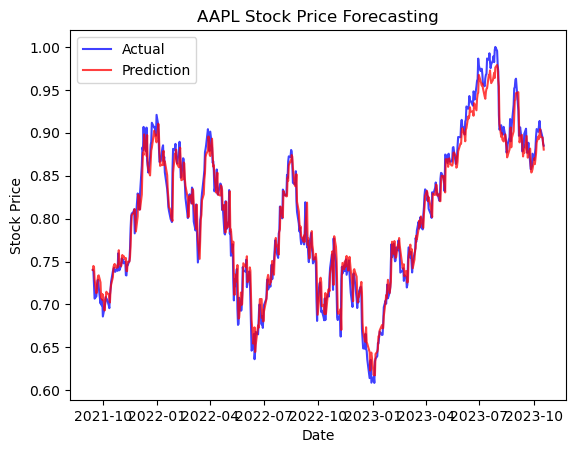

In [9]:
plt.plot(test_date, y_test, 'b-', test_date, y_pred, 'r-', alpha=0.75)
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{COMPANY} Stock Price Forecasting')
plt.show()

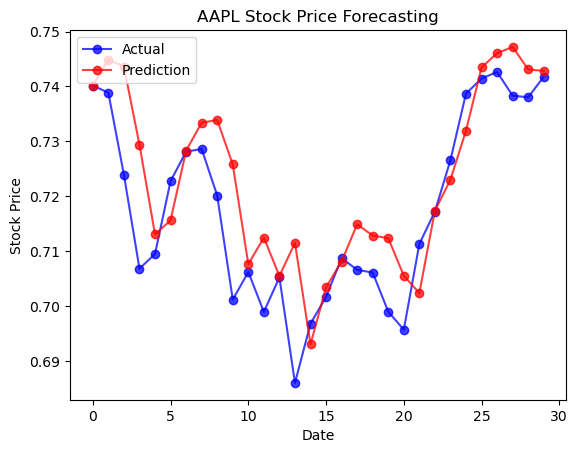

In [10]:
plt.plot(range(30), y_test[:30], 'bo-', range(30), y_pred[:30], 'ro-', alpha=0.75)
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{COMPANY} Stock Price Forecasting')
plt.show()

69/69 [==============================] - 0s 807us/step


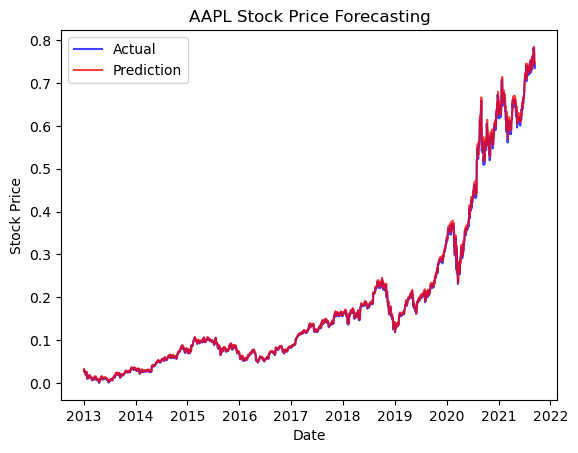

In [11]:
y_pred = model.predict(x_train)
plt.plot(train_date, y_train, 'b-', train_date, y_pred, 'r-', alpha=0.75)
plt.legend(['Actual', 'Prediction'], loc='upper left')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{COMPANY} Stock Price Forecasting')
plt.show()

---

## Idea

x = actual stock price on day 1  
y = actual stock price on day 2  
y_pred = predicted stock price on day 2 based on the previous day  

a = y - x # actual stock price difference compared to the day before  
b = y_pred - x # predicted stock price difference compared to the day before  

if b > 0:  
    - stock price is predicted to increase the next day  
    - if haven't bought the stock, time to buy  
else:  
    - stock price is predicted to decrease the next day  
    - if have some stocks already, time to sell  

In [12]:
model.predict(x_test[10].reshape(-1, 1))

1/1 [==============================] - 0s 12ms/step


array([[0.7076203]], dtype=float32)

```python
test_res1 = list()
y_pred = model.predict(x_test)
for i in range(len(x_test)):
    res_actual = y_test[i] > x_test[i]
    res_pred = y_pred[i] > x_test[i]
    test_res1.append(bool(res_actual == res_pred))
```

In [13]:
# ```python
test_res2 = list()
for i in range(len(x_test)):
    y_pred1 = model.predict(x_test[i].reshape(-1, 1), verbose=0)
    # y_pred2 = model.predict(y_pred1, verbose=0)

    res_actual = y_test[i] > x_test[i]
    res_pred = y_pred1 > x_test[i]
    test_res2.append(bool(res_actual == res_pred))

print('Done')
# ```

Done


288 528
54.54545454545454


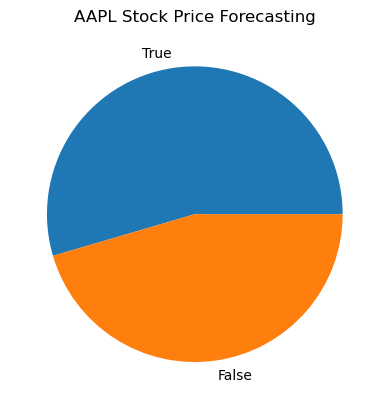

In [14]:
dataset = test_res2
s = sum(dataset)

print(s, len(dataset))
print(s/len(dataset)*100)

plt.pie([s, len(dataset) - s], labels=['True', 'False'])
plt.title(f'{COMPANY} Stock Price Forecasting')
plt.show()

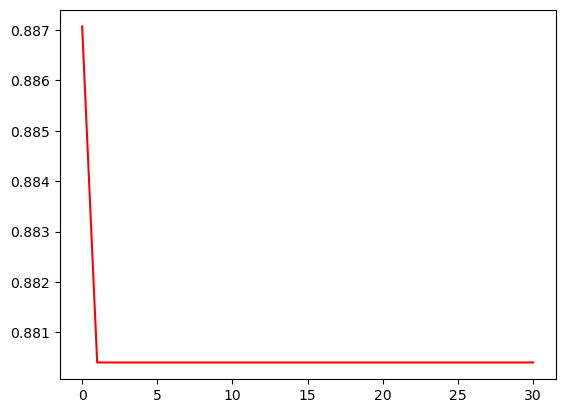

In [16]:
future_set = list()
future_set.append(x_test[-1])
for i in range(30):
    y_pred = model.predict(x_test[-1].reshape(-1, 1), verbose=0)
    future_set.append(y_pred[0])

plt.plot(range(len(future_set)), future_set, 'r-')